In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.linalg import svdvals
from sklearn.preprocessing import StandardScaler
import sys
sys.path.insert(1, '/content/drive/MyDrive/ADM/HW4')
from utils import *
import csv
import warnings
warnings.filterwarnings("ignore")

#Excersise 1

## Convert m3 to Wave

In [ ]:
data_folder = Path("/content/drive/MyDrive/ADM/HW4/mp3")
mp3_tracks = data_folder.glob("*/*/*.mp3")

In [ ]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

## Load Peak

In [ ]:
N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 30
OFFSET = 1.0

In [ ]:
data = Path("/content/drive/MyDrive/ADM/HW4/mp3")
tracks = data.glob("*/*/*.wav")

In [ ]:
# read all track and save the peaks in 2 files, the first one (peaks_songs) contains information about peaks, and the second one(song) contain information of song like 
# song name

with open('peaks_songs.csv', mode='w') as peaks_songs, open('songs.csv', mode='w') as file_songs :
    file_csv = csv.writer(peaks_songs, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    file_songs = csv.writer(file_songs, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for idx, audio in enumerate(tqdm(tracks)):
        track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
        times = librosa.frames_to_time(np.arange(len(onset_env)),
                                sr=sr, hop_length=HOP_SIZE)
        file_songs.writerow([str(audio), idx])  # adding a row
        for peak in range(len(peaks)):
            file_csv.writerow([onset_env[peaks[peak]], track[peaks[peak]], idx, times[peak]])
            #df3.loc[-1] = [peaks[peaks[peak]] , idx, times[peak]]  # adding a row


In [ ]:
# download query
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track1.wav;
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track2.wav;
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track3.wav;
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track4.wav;
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track5.wav;
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track6.wav;
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track7.wav;
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track8.wav;
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track9.wav;
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track10.wav;

In [ ]:
# read file peaks_songs
colnames = ["peak","peak_track", "song_id", "time_peak"]
df_peak_song = pd.read_csv("/content/drive/MyDrive/ADM/HW4/peaks_songs2.csv",names=colnames, header=None)
df_peak_song["song_id"] = df_peak_song["song_id"].astype('int32', copy=False)

In [ ]:
# read file song
colnames = ["song_name", "song_id"]
df_song = pd.read_csv("/content/drive/MyDrive/ADM/HW4/songs2.csv",names=colnames, header=None)
df_song['song_name'] = df_song['song_name'].str.split('/').str[-1]

In [ ]:
df_peak_song.head()

,peak,peak_track,song_id,time_peak
0,4.240781,-0.119971,0,0.00000
1,3.576850,-0.153133,0,0.02322
2,6.882774,-0.163018,0,0.04644
3,4.992823,0.002067,0,0.06966
4,5.099923,0.060033,0,0.09288


In [ ]:
array_peak = df_peak_song['peak'].round(decimals=1).unique() #array of frequence, and we approximate the values for the hash function 
array_song = df_song['song_id'] 
d = pd.DataFrame(0, index=array_peak, columns=array_song) # matrix len frequences x len song
d.columns = d.columns.astype(str) # change type of column name

In [ ]:
d.head()

song_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412
4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# assign 1 when frequency_number in song
for index, row in df_peak_song.iterrows():
    d.loc[row['peak'].round(decimals=1), str(int(row['song_id']))] = 1
d.head()

song_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412
4.2,1,0,1,1,1,1,0,0,1,1,1,0,0,1,1,0,0,0,0,1,1,1,0,0,1,0,1,0,1,1,0,1,1,1,0,1,1,1,0,1,...,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,0,0,1,1,0,1,1,0,1,0,1,1,1,1,1,1,0,0,1,0,1,1,0,0,0
3.6,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,...,1,0,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,0
6.9,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,1,0,1,...,1,1,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
5.0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,1,1,0,0,...,1,0,1,1,1,1,0,1,1,1,0,0,1,0,1,0,0,0,1,1,0,1,0,1,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0
5.1,1,0,1,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,...,0,1,1,0,0,1,0,1,1,1,1,1,1,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0


## Min Hash

In [ ]:
#Threshold 0.93 -> (1/r_bin) ^ (1/number_row_for_Each_bucket)
r_bin = 2  # number element for each column (hash)
number_of_permutations = 20
#permutaions contains the index order for each permutation
matrix_signature, permutations = create_matrix_signature(number_of_permutations, d)
buckets = create_buckets(matrix_signature, r_bin, permutations)
THRESHOLD = 0.7
tracks = os.listdir("/content")
tracks.sort()
print("{:<20} {:<60} {:<80}".format('Query', 'Result','Similarity'))
for query in tracks:
    if query.endswith(".wav"):
        track1, sr, onset_env1, peaks1 = load_audio_peaks(query, OFFSET,DURATION, HOP_SIZE)
        query_peaks = np.float64(onset_env1[peaks1]).round(decimals=1)
        buckets_query = create_buckets_query(permutations, d, query_peaks, r_bin)
        print(query)
        find_matches(query, buckets_query , buckets, THRESHOLD)

Query                Result                                                       Similarity                                                                      
track1.wav
                      03-Dream_On.wav                                             1.0                                                                             
track10.wav
                      01-Black_Friday.wav                                         1.0                                                                             
track2.wav
                      06-I_Want_To_Break_Free.wav                                 1.0                                                                             
track3.wav
                      07-October.wav                                              1.0                                                                             
track4.wav
                      04-Ob-La-Di_Ob-La-Da.wav                                    1.0                                            

Above there the best matches of queries with THRESHOLD 0.7, r_bin equal to 2 and 20 permutations.

In [ ]:
# threshold 0.574
r_bin = 4  
number_of_permutations = 20
#permutaions contains the index order for each permutation
matrix_signature, permutations = create_matrix_signature(number_of_permutations, d)
buckets = create_buckets(matrix_signature, r_bin, permutations)
THRESHOLD = 0.6
tracks = os.listdir("/content")
tracks.sort()
print("{:<20} {:<60} {:<80}".format('Query', 'Result','Similarity'))
for query in tracks:
    if query.endswith(".wav"):
        track1, sr, onset_env1, peaks1 = load_audio_peaks(query, OFFSET,DURATION, HOP_SIZE)
        query_peaks = np.float64(onset_env1[peaks1]).round(decimals=1)
        buckets_query = create_buckets_query(permutations, d, query_peaks, r_bin)
        print(query)
        find_matches(query, buckets_query , buckets, THRESHOLD)

Query                Result                                                       Similarity                                                                      
track1.wav
                      03-Dream_On.wav                                             1.0                                                                             
                      08-80.wav                                                   0.75                                                                            
track10.wav
                      01-Black_Friday.wav                                         1.0                                                                             
track2.wav
                      06-I_Want_To_Break_Free.wav                                 1.0                                                                             
track3.wav
                      07-October.wav                                              1.0                                                       

Above there the best matches of queries with THRESHOLD 0.6, r_bin equal to 4 and 20 permutations.

In [ ]:
r_bin = 4  
number_of_permutations = 10
#permutaions contains the index order for each permutation
matrix_signature, permutations = create_matrix_signature(number_of_permutations, d)
buckets = create_buckets(matrix_signature, r_bin, permutations)
THRESHOLD = 0.65
tracks = os.listdir("/content")
tracks.sort()
print("{:<20} {:<60} {:<80}".format('Query', 'Result','Similarity'))
for query in tracks:
    if query.endswith(".wav"):
        track1, sr, onset_env1, peaks1 = load_audio_peaks(query, OFFSET,DURATION, HOP_SIZE)
        query_peaks = np.float64(onset_env1[peaks1]).round(decimals=1)
        buckets_query = create_buckets_query(permutations, d, query_peaks, r_bin)
        print(query)
        find_matches(query, buckets_query , buckets, THRESHOLD)

Query                Result                                                       Similarity                                                                      
track1.wav
                      03-Dream_On.wav                                             1.0                                                                             
                      03-What_She_s_Doing_Now.wav                                 0.8                                                                             
                      05-Sarah_Edit_.wav                                          0.8                                                                             
                      01-You.wav                                                  0.8                                                                             
                      17-Fight.wav                                                0.8                                                                             
           

Above there the best matches of queries with THRESHOLD 0.65, r_bin equal to 4 and 10 permutations.
As we can see, if we consider a smaller THRESHOLD, we obatain more results that surpass it. On the other hand if we increase the number of rbins we will have a bigger THRESHOLD, such that it will get closer to one; this will provide us less results, and more specifically, when the THRESHOLD is equal to one, we will most luckily obtain as result only the correct match. This also happens when we increase the number of permutations. 

#Excersise 2

## Cleaning data

In [ ]:
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/echonest.csv
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/features.csv
!wget https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/tracks.csv

In [ ]:
# read the data
df1= pd.read_table('/content/echonest.csv', sep=',')
df2= pd.read_table('/content/features.csv', sep=',')
df3= pd.read_table('/content/tracks.csv', sep=',')

In [ ]:
# merge the data
df=(df1.merge(df2, on='track_id')).merge(df3, on='track_id')

In [ ]:
# clear data and drop useless columns
df = df.drop(df.columns[df.isnull().sum() > 303] & df.columns[df.dtypes != 'O'], axis=1)
df[['artist_date_created','album_date_created']] = df[['artist_date_created','album_date_created']].fillna(method='bfill')
df[df.columns[df.dtypes == 'O']] = df[df.columns[df.dtypes == 'O']].fillna("unknow")
df = df.drop(['track_license', 'artist_tags','track_tags','album_tags','set_split','set_subset'], axis=1);

In [ ]:
# take only year from date and convert type to int
df.album_date_created = df.album_date_created.str[0:4]
df['album_date_created'] = df['album_date_created'].astype(int)
df.artist_date_created = df.artist_date_created.str[0:4]
df['artist_date_created'] = df['artist_date_created'].astype(int)
df.track_date_created = df.track_date_created.str[0:4]
df['track_date_created'] = df['track_date_created'].astype(int)

## PCA

In [ ]:
from sklearn.decomposition import PCA
from scipy.linalg import svdvals
from sklearn.preprocessing import StandardScaler

In [ ]:
# take away the object type columns and track duration
l = list(df.columns[df.dtypes=='O'])
l.append('track_duration')
df_obj = df[l]
df = df.drop(l, axis=1)
df.shape

(13129, 773)

In [ ]:
# normalize the data and apply the PCA
df_scaled = StandardScaler()
scaler = df_scaled.fit_transform(df)
pca = PCA(n_components = 0.8)
dfn = pca.fit_transform(scaler)
dfn = pd.DataFrame(dfn)

In [ ]:
# we retake the duration of the track
dfn['track_duration'] = df_obj['track_duration']
dfn.shape

(13129, 118)

##Kmeans

In [ ]:
def k_means(data, number_cluster):
    """
    Returns a tuple where the first element is the matrix_signature, and the second one is the matrix of permutations

            Parameters:
                    data(numpy matrix)
                    number_cluster(int)

            Returns:
                    cluster_rows(dict): as a key we have the cluster, and as value the row containing in the cluster
                    centroids (list)
                    row_cluster (list): list of preditions 

    """
    index_clusters = np.random.choice(data.shape[0], number_cluster, replace=False)
    centroids = data[index_clusters]
    cluster_rows = dict()
    row_cluster = [0 for _ in range(data.shape[0])]
    for epoch in range(100):
        cluster_rows = {i: [] for i in range(number_cluster)}
        for i in range(data.shape[0]):
            #cluster_choise = np.linalg.norm(centroids - data[i], axis=1).argmin()
            cluster_choise = euclidian_distance(centroids, data[i]).argmin()
            row_cluster[i] = cluster_choise
            cluster_rows[cluster_choise].append(data[i])
        prev = centroids.copy()
        for i in range(len(centroids)):
            centroids[i] = np.array(cluster_rows[i]).mean(axis=0)
        if (prev == centroids).all():
            break
    return cluster_rows, centroids, row_cluster

## silhouette code

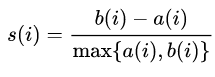


where:
- a(i) is the mean of all the distances between the point i and every othe point in the same cluster of i.
- b(i) is the mean of all the distances between the point i and every point in the closest cluster to the cluster of i.

In [ ]:
def silhoutte(cluster_rows, centroids, data, row_cluster):
    b = []
    a = []
    cluster_distance = closest_cluster(centroids)
    for i in range(data.shape[0]):
        a.append(np.linalg.norm(cluster_rows[row_cluster[i]] - data[i], axis=1).mean())
        b.append(np.linalg.norm(cluster_rows[cluster_distance[row_cluster[i]]] - data[i], axis=1).mean())
    a = np.array(a)
    b = np.array(b)
    return (np.abs(a - b) / np.maximum(a,b)).mean()

In [ ]:
# Function to find the closest cluster from for each cluster
import sys
def closest_cluster(centroids):
    result = dict()
    for cluster in range(len(centroids)):
        distance_with_other = []
        for cluster_2 in range(len(centroids)):
            if cluster != cluster_2:
                distance_with_other.append(np.linalg.norm(centroids[cluster] - centroids[cluster_2]))
            else:
                distance_with_other.append(sys.maxsize)
        result[cluster] = np.argmin(distance_with_other)
    return result

## RUN KMEANS

In [ ]:
from tqdm import tqdm
from sklearn.metrics import silhouette_score
distances = [] 
d_k = []
silhouttes = []
gaps = []
np.random.seed(0)
data = np.array(dfn.values.tolist())
# we iterate from 2 to 15 to choise the best cluster
for number_cluster in tqdm(range(2,15)):
    cluster_rows, centroids, row_cluster = k_means(data, number_cluster)
    distances.append(distance_from_centroids(cluster_rows, centroids))
    d_k.append(number_cluster)
    s = silhoutte(cluster_rows, centroids, data, row_cluster)
    init_gaps = []
    # calcuate GAP
    for i in range(3):
        randomReference = np.random.random_sample(size=data.shape)
        cluster_rows, centroids, row_cluster = k_means(data, number_cluster)   
        init_gaps.append(distance_from_centroids(cluster_rows, centroids))
    gaps.append(np.log(np.array(init_gaps).mean()) - np.log(distances[-1]))
    silhouttes.append(s)

## Elbow

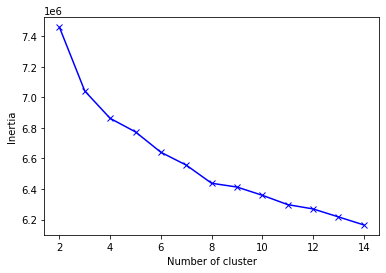

In [ ]:
import matplotlib.pyplot as plt

plt.plot(d_k, distances, 'bx-')
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.show()

## silhouttes

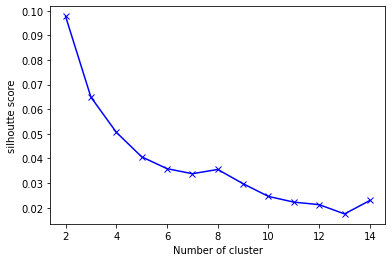

In [ ]:
plt.plot(d_k, silhouttes, 'bx-')
plt.xlabel('Number of cluster')
plt.ylabel('silhoutte score')
plt.show()

## GAP

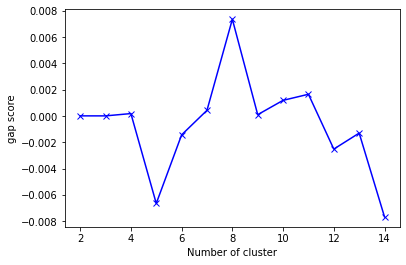

In [ ]:
plt.plot(d_k, gaps, 'bx-')
plt.xlabel('Number of cluster')
plt.ylabel('gap score')
plt.show()

As shown by the plots the optimal number of k seems to be 8.

## Kmean with the optimal K

In [ ]:
data = np.array(dfn.values.tolist())
cluster_rows, centroids, row_cluster = k_means(data, 8)

In [ ]:
from sklearn.cluster import KMeans
kmeanModel = KMeans(n_clusters=8, init='k-means++').fit(data)
y_predicted = kmeanModel.fit_predict(data)

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(y_predicted,row_cluster )

0.5632066430827343

As we can see there is a differnce between the results of kmeans and kmeans++: the similarity, according to the ARI (adjusted round index) , is equal to 56%. This is because the kmeans++ has a different initialization for the starting centroids.

## Analysing our results!

In [ ]:
df_analysis = df[['audio_features_tempo', 'track_date_created', 'audio_features_danceability']]
df_analysis[['track_duration', 'album_type', 'track_genre_top']] = df_obj[['track_duration', 'album_type', 'track_genre_top']]

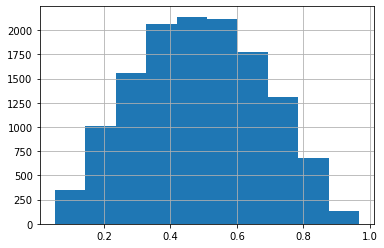

In [ ]:
#we leave an example where you can see who we chose the range for each bin while descritizing (we used for each transformation the histogram to see the distribution)
df['audio_features_danceability'].hist()

In [ ]:
df_analysis['audio_features_tempo'] = np.digitize(df_analysis['audio_features_tempo'],[11, 80, 130, 180])
df_analysis['track_duration'] = np.digitize(df_analysis['track_duration'], [0, 160, 220, 380])
df_analysis['audio_features_danceability'] = np.digitize(df_analysis['audio_features_danceability'],[0, 0.35, 0.5, 0.65])

In [ ]:
df_analysis.head()

,audio_features_tempo,track_date_created,audio_features_danceability,track_duration,album_type,track_genre_top
0,3,2008,4,2,Album,Hip-Hop
1,2,2008,3,3,Album,Hip-Hop
2,2,2008,4,2,Album,Hip-Hop
3,2,2008,4,2,Album,Pop
4,2,2008,3,2,Album,Hip-Hop


In [ ]:
df_analysis['#Cluster'] = row_cluster
df_analysis['Predict'] = row_cluster

In [ ]:
df_analysis

,audio_features_tempo,track_date_created,audio_features_danceability,track_duration,album_type,track_genre_top,#Cluster,Predict
0,3,2008,4,2,Album,Hip-Hop,1,1
1,2,2008,3,3,Album,Hip-Hop,7,7
2,2,2008,4,2,Album,Hip-Hop,1,1
3,2,2008,4,2,Album,Pop,1,1
4,2,2008,3,2,Album,Hip-Hop,1,1
...,...,...,...,...,...,...,...,...
13124,3,2015,4,3,Album,unknow,7,7
13125,2,2015,4,3,Album,unknow,7,7
13126,2,2015,3,4,Album,unknow,4,4
13127,3,2015,3,3,Album,unknow,7,7


## 2.3 - 2.4 - 2.5

In [ ]:
pv = df_analysis.pivot_table(index=['audio_features_tempo'], columns='#Cluster',  aggfunc=len)
pv['Predict']

#Cluster,0,1,2,3,4,5,6,7
audio_features_tempo,,,,,,,,
1,254,317,6,17,156,24,89,248
2,1292,2190,19,44,1008,73,291,1992
3,856,1437,13,14,543,32,151,1197
4,246,283,2,2,93,14,35,191


In [ ]:
((pv['Predict'] / pv['Predict'].sum(axis= 0)) * 100).round(1).astype(str) + '%'

#Cluster,0,1,2,3,4,5,6,7
audio_features_tempo,,,,,,,,
1,9.6%,7.5%,15.0%,22.1%,8.7%,16.8%,15.7%,6.8%
2,48.8%,51.8%,47.5%,57.1%,56.0%,51.0%,51.4%,54.9%
3,32.3%,34.0%,32.5%,18.2%,30.2%,22.4%,26.7%,33.0%
4,9.3%,6.7%,5.0%,2.6%,5.2%,9.8%,6.2%,5.3%


As we can see, the variable `audio_features_tempo` doesn't influence the clustering: in fact for each cluster the distribution of the variable it's not much different.  

In [ ]:
pv = df_analysis.pivot_table(index=['track_date_created'], columns='#Cluster',  aggfunc=len, fill_value=0)
pv['Predict']

#Cluster,0,1,2,3,4,5,6,7
track_date_created,,,,,,,,
2008,424,548,13,13,209,30,82,369
2009,803,1343,10,28,519,48,182,1037
2010,724,1106,11,19,554,34,159,1063
2011,382,558,6,17,254,27,92,531
2012,105,228,0,0,62,0,10,174
2013,97,198,0,0,41,2,14,155
2014,54,130,0,0,84,1,15,167
2015,59,116,0,0,77,1,12,132


In [ ]:
((pv['Predict'] / pv['Predict'].sum(axis= 0)) * 100).round(1).astype(str) + '%'

#Cluster,0,1,2,3,4,5,6,7
track_date_created,,,,,,,,
2008,16.0%,13.0%,32.5%,16.9%,11.6%,21.0%,14.5%,10.2%
2009,30.3%,31.8%,25.0%,36.4%,28.8%,33.6%,32.2%,28.6%
2010,27.3%,26.2%,27.5%,24.7%,30.8%,23.8%,28.1%,29.3%
2011,14.4%,13.2%,15.0%,22.1%,14.1%,18.9%,16.3%,14.6%
2012,4.0%,5.4%,0.0%,0.0%,3.4%,0.0%,1.8%,4.8%
2013,3.7%,4.7%,0.0%,0.0%,2.3%,1.4%,2.5%,4.3%
2014,2.0%,3.1%,0.0%,0.0%,4.7%,0.7%,2.7%,4.6%
2015,2.2%,2.7%,0.0%,0.0%,4.3%,0.7%,2.1%,3.6%


Even in this case, creating the pivot table with the variable `track_date_created`, the conditioning distributions of the variable wrt the clustering look pretty similar, which means the clustering doen't depend much from when the track was created.

In [ ]:
pv = df_analysis.pivot_table(index=['audio_features_danceability'], columns='#Cluster',  aggfunc=len)
pv['Predict']

#Cluster,0,1,2,3,4,5,6,7
audio_features_danceability,,,,,,,,
1,732,963,18,52,506,88,245,794
2,705,1213,16,20,483,33,136,900
3,633,1142,4,4,442,18,83,1007
4,578,909,2,1,369,4,102,927


In [ ]:
((pv['Predict'] / pv['Predict'].sum(axis= 0)) * 100).round(1).astype(str) + '%'

#Cluster,0,1,2,3,4,5,6,7
audio_features_danceability,,,,,,,,
1,27.6%,22.8%,45.0%,67.5%,28.1%,61.5%,43.3%,21.9%
2,26.6%,28.7%,40.0%,26.0%,26.8%,23.1%,24.0%,24.8%
3,23.9%,27.0%,10.0%,5.2%,24.6%,12.6%,14.7%,27.8%
4,21.8%,21.5%,5.0%,1.3%,20.5%,2.8%,18.0%,25.6%


As we can see, the variable `audio_features_danceability` doesn't influence the clustering:  it might seem to be a certain dependency, however, looking at the non-normalized table, we can see that the coloumns which have a different distribution have a very few data; that's why we think it's better to say that the variable hasn't a big influence in the choice of cluster.

In [ ]:
pv = df_analysis.pivot_table(index=['track_duration'], columns='#Cluster',  aggfunc=len, fill_value=0)
pv['Predict']

#Cluster,0,1,2,3,4,5,6,7
track_duration,,,,,,,,
1,2648,811,0,0,0,0,0,0
2,0,3416,0,0,0,0,0,25
3,0,0,0,0,1311,0,0,3603
4,0,0,40,77,489,143,566,0


In [ ]:
((pv['Predict'] / pv['Predict'].sum(axis= 0)) * 100).round(1).astype(str) + '%'

#Cluster,0,1,2,3,4,5,6,7
track_duration,,,,,,,,
1,100.0%,19.2%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2,0.0%,80.8%,0.0%,0.0%,0.0%,0.0%,0.0%,0.7%
3,0.0%,0.0%,0.0%,0.0%,72.8%,0.0%,0.0%,99.3%
4,0.0%,0.0%,100.0%,100.0%,27.2%,100.0%,100.0%,0.0%


As shown in the above pivot table, the distribution of `track_duration` changes a lot while conditioning to the clustering: this means this variable really influenced the clustering.

In [ ]:
pv = df_analysis.pivot_table(index=['album_type'], columns='#Cluster',  aggfunc=len, fill_value=0)
pv['Predict']

#Cluster,0,1,2,3,4,5,6,7
album_type,,,,,,,,
Album,1914,3072,9,21,1335,72,349,2777
Contest,11,2,0,0,0,0,0,1
Live Performance,227,334,26,38,175,35,70,273
Radio Program,419,656,5,17,236,34,121,455
Single Tracks,22,50,0,0,17,1,7,45
unknow,55,113,0,1,37,1,19,77


In [ ]:
((pv['Predict'] / pv['Predict'].sum(axis= 0)) * 100).round(1).astype(str) + '%'

#Cluster,0,1,2,3,4,5,6,7
album_type,,,,,,,,
Album,72.3%,72.7%,22.5%,27.3%,74.2%,50.3%,61.7%,76.5%
Contest,0.4%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
Live Performance,8.6%,7.9%,65.0%,49.4%,9.7%,24.5%,12.4%,7.5%
Radio Program,15.8%,15.5%,12.5%,22.1%,13.1%,23.8%,21.4%,12.5%
Single Tracks,0.8%,1.2%,0.0%,0.0%,0.9%,0.7%,1.2%,1.2%
unknow,2.1%,2.7%,0.0%,1.3%,2.1%,0.7%,3.4%,2.1%


In this case, it happens exactly the same thing explained for the pivot table of the variable `audio_features_danceability`.

## 2.6

In [ ]:
pv = df_analysis.pivot_table(index=['track_genre_top'], columns='#Cluster',  aggfunc=len, fill_value=0)
pv['Predict']

#Cluster,0,1,2,3,4,5,6,7
track_genre_top,,,,,,,,
Blues,23,4,26,0,0,0,5,8
Classical,64,23,38,5,13,26,59,37
Electronic,568,149,645,8,21,10,347,422
Experimental,5,0,2,0,0,0,10,0
Folk,293,40,237,2,12,1,151,138
Hip-Hop,338,6,243,1,1,1,259,61
Instrumental,27,2,14,4,0,0,30,7
International,33,5,50,1,0,0,10,34
Jazz,38,37,52,4,12,3,32,63


In [ ]:
((pv['Predict'] / pv['Predict'].sum(axis= 0)) * 100).round(1).astype(str) + '%'

#Cluster,0,1,2,3,4,5,6,7
track_genre_top,,,,,,,,
Blues,0.5%,0.7%,0.7%,0.0%,0.0%,0.0%,0.2%,0.4%
Classical,1.5%,4.1%,1.0%,12.5%,9.1%,33.8%,2.2%,2.1%
Electronic,13.4%,26.3%,17.8%,20.0%,14.7%,13.0%,13.1%,23.7%
Experimental,0.1%,0.0%,0.1%,0.0%,0.0%,0.0%,0.4%,0.0%
Folk,6.9%,7.1%,6.5%,5.0%,8.4%,1.3%,5.7%,7.7%
Hip-Hop,8.0%,1.1%,6.7%,2.5%,0.7%,1.3%,9.8%,3.4%
Instrumental,0.6%,0.4%,0.4%,10.0%,0.0%,0.0%,1.1%,0.4%
International,0.8%,0.9%,1.4%,2.5%,0.0%,0.0%,0.4%,1.9%
Jazz,0.9%,6.5%,1.4%,10.0%,8.4%,3.9%,1.2%,3.5%


Looking at the pivot table for the variable `track_genre_top` we can see that the task to have a clustering according to the genre of the song is complete fail. For each cluster, not considering the "unknow", the dominant genre is "rock", except for the cluster **5** (where it's classical).


Looking at tables, we observed that a smaller number of clusters would have provided a better result: in fact some clusters have just a few data. if we could re-do all the analysis we would choose four or five clusters. Unfortunately the plots tricked us to pick 8 as number of clusters and there isn't enough time to do all again.

## 2.7

In [ ]:
df_merge = df2.merge(df3, on='track_id')

In [ ]:
df_merge.shape

(106574, 571)

In [ ]:
df_merge = df_merge.drop(df_merge.columns[df_merge.isnull().sum() > 1000] & df_merge.columns[df_merge.dtypes != 'O'], axis=1)

In [ ]:
df_merge[['artist_date_created','album_date_created']] = df_merge[['artist_date_created','album_date_created']].fillna(method='bfill')
df_merge[df_merge.columns[df_merge.dtypes == 'O']] = df_merge[df_merge.columns[df_merge.dtypes == 'O']].fillna("unknow")
df_merge = df_merge.drop(['track_license', 'artist_tags','track_tags','album_tags','set_split','set_subset'], axis=1);

In [ ]:
# take only year from date and convert type to int
df_merge.album_date_created = df_merge.album_date_created.str[0:4]
df_merge['album_date_created'] = df_merge['album_date_created'].astype(int)
df_merge.artist_date_created = df_merge.artist_date_created.str[0:4]
df_merge['artist_date_created'] = df_merge['artist_date_created'].astype(int)
df_merge.track_date_created = df_merge.track_date_created.str[0:4]
df_merge['track_date_created'] = df_merge['track_date_created'].astype(int)

In [ ]:
l = list(df_merge.columns[df_merge.dtypes=='O'])
l.extend(['track_duration','track_id'])
df_merge_obj = df_merge[l]
df_merge = df_merge.drop(l, axis=1)
df_merge.shape

(106574, 535)

In [ ]:
df_merge.head()

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,...,tonnetz_min_03,tonnetz_min_04,tonnetz_min_05,tonnetz_min_06,tonnetz_skew_01,tonnetz_skew_02,tonnetz_skew_03,tonnetz_skew_04,tonnetz_skew_05,tonnetz_skew_06,tonnetz_std_01,tonnetz_std_02,tonnetz_std_03,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01,album_comments,album_date_created,album_favorites,album_id,album_listens,album_tracks,artist_comments,artist_date_created,artist_favorites,artist_id,track_bit_rate,track_comments,track_date_created,track_favorites,track_interest,track_listens,track_number
0,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,1.347792,1.237658,0.692500,0.569344,0.597041,0.625864,0.567330,0.443949,0.487976,0.497327,0.574435,0.579241,0.620102,0.586945,0.474300,0.369816,0.236119,0.228068,0.222830,0.221415,0.229238,0.248795,0.196245,0.175809,0.200713,0.319972,0.482825,0.387652,0.249082,0.238187,...,-0.185687,-0.140306,-0.048525,-0.089286,0.752462,0.262607,0.200944,0.593595,-0.177665,-1.424201,0.019809,0.029569,0.038974,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,0,2008,4,1,6073,7,0,2008,9,1,256000,0,2008,2,4656,1293,3
1,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,1.038253,1.292235,0.677641,0.584248,0.581271,0.581182,0.454241,0.464841,0.542833,0.664720,0.511329,0.530998,0.603398,0.547428,0.232784,0.229469,0.225674,0.216713,0.220512,0.242744,0.369235,0.420716,0.312129,0.242748,0.264292,0.225683,0.230579,0.228059,0.209370,0.202267,...,-0.164613,-0.304375,-0.024958,-0.055667,0.265541,-0.131471,0.171930,-0.990710,0.574556,0.556494,0.026316,0.018708,0.051151,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,0,2008,4,1,6073,7,0,2008,9,1,256000,0,2008,1,1470,514,4
2,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,0.268932,1.125141,0.611014,0.651471,0.494528,0.448799,0.468624,0.454021,0.497172,0.559755,0.671287,0.610565,0.551663,0.603413,0.258420,0.303385,0.250737,0.218562,0.245743,0.236018,0.275766,0.293982,0.346324,0.289821,0.246368,0.220939,0.255472,0.293571,0.245253,0.222065,...,-0.359463,-0.166667,-0.038546,-0.146136,1.212025,0.218381,-0.419971,-0.014541,-0.199314,-0.925733,0.025550,0.021106,0.084997,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,0,2008,4,1,6073,7,0,2008,9,1,256000,0,2008,6,1933,1151,6
3,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,4.326824,1.300406,0.461840,0.540411,0.446708,0.647553,0.591908,0.513306,0.651501,0.516887,0.511479,0.478263,0.638766,0.638495,0.229882,0.286978,0.240096,0.226792,0.192443,0.288410,0.413348,0.349137,0.268424,0.243144,0.268941,0.236763,0.230555,0.280229,0.234060,0.226213,...,-0.273549,-0.343055,-0.052284,-0.029836,-0.135219,-0.275780,0.015767,-1.094873,1.164041,0.246746,0.021413,0.031989,0.088197,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,0,2008,4,6,47632,2,3,2008,74,6,192000,0,2008,178,54881,50135,1
4,-

### 2.7.1

In [ ]:
df_scaled = StandardScaler()
scaler = df_scaled.fit_transform(df_merge)
pca = PCA(n_components = 0.8)
dfn_2 = pca.fit_transform(scaler)
dfn_2 = pd.DataFrame(dfn_2)

In [ ]:
# we retake the duration of the track
dfn_2['track_duration'] = df_merge_obj['track_duration']
dfn_2.shape

(106574, 91)

### 2.7.2

In [ ]:
inertia = []
for number_cluster in tqdm(range(2,15)):
    kmean = KMeans(n_clusters=number_cluster, init = 'k-means++').fit(dfn_2)
    y_predicted = kmean.fit_predict(dfn_2)
    inertia.append(kmean.inertia_)

  0%|          | 0/13 [00:00<?, ?it/s]

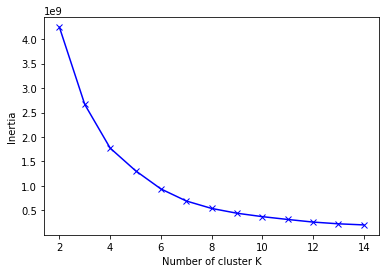

In [ ]:
plt.plot(np.arange(2,15), inertia, 'bx-')
plt.xlabel('Number of cluster K')
plt.ylabel('Inertia')
plt.show()

As we can see from the plot the optimal number of clusters seems to be 7, but, in order to make the comparision easier, we take 8, as in the previous step. This also seems to be correct because the plot doesn't show a defined elbow, but it decreases pretty smoothly.

In [ ]:
kmean = KMeans(n_clusters=8, init = 'k-means++').fit(dfn_2)
y_predicted = kmean.fit_predict(dfn_2)

### 2.7.3

In [ ]:
df_analysis_2 = df_merge[['artist_date_created', 'track_date_created']]
df_analysis_2[['track_duration', 'album_type', 'track_genre_top']] = df_merge_obj[['track_duration', 'album_type', 'track_genre_top']]

In [ ]:
df_analysis_2['track_duration'] = np.digitize(df_analysis_2['track_duration'], [0, 160, 220, 380])

In [ ]:
df_analysis_2['#Cluster'] = y_predicted
df_analysis_2['Predict'] = y_predicted

In [ ]:
pv = df_analysis_2.pivot_table(index=['artist_date_created'], columns='#Cluster',  aggfunc=len, fill_value=0)
((pv['Predict'] / pv['Predict'].sum(axis= 0)) * 100).round(1).astype(str) + '%'

#Cluster,0,1,2,3,4,5,6,7
artist_date_created,,,,,,,,
2008,6.6%,12.7%,7.3%,13.7%,7.4%,6.7%,25.0%,9.4%
2009,12.8%,17.5%,19.3%,22.4%,11.5%,16.0%,0.0%,14.4%
2010,17.4%,15.8%,17.8%,17.0%,14.5%,17.4%,0.0%,14.0%
2011,12.6%,14.6%,11.3%,15.9%,14.6%,10.2%,0.0%,16.0%
2012,12.3%,5.2%,10.3%,5.1%,10.4%,11.5%,0.0%,8.1%
2013,12.0%,10.4%,9.8%,6.1%,12.9%,11.3%,0.0%,10.6%
2014,7.3%,8.2%,6.1%,6.9%,9.3%,6.9%,75.0%,8.1%
2015,7.4%,4.7%,9.3%,4.0%,6.9%,9.3%,0.0%,7.0%
2016,9.5%,9.6%,7.1%,8.7%,10.1%,8.6%,0.0%,10.0%


In [ ]:
pv = df_analysis_2.pivot_table(index=['track_date_created'], columns='#Cluster',  aggfunc=len, fill_value=0)
((pv['Predict'] / pv['Predict'].sum(axis= 0)) * 100).round(1).astype(str) + '%'

#Cluster,0,1,2,3,4,5,6,7
track_date_created,,,,,,,,
2008,2.4%,3.7%,3.0%,6.5%,2.3%,2.5%,25.0%,3.4%
2009,9.0%,15.6%,12.5%,13.7%,8.2%,10.0%,0.0%,10.4%
2010,11.9%,14.8%,12.9%,19.1%,10.5%,12.0%,0.0%,11.2%
2011,10.8%,15.2%,11.0%,8.7%,12.5%,10.0%,0.0%,16.1%
2012,12.5%,8.2%,11.2%,4.7%,11.2%,11.8%,0.0%,9.7%
2013,12.4%,11.9%,13.7%,11.2%,12.2%,13.0%,0.0%,11.1%
2014,10.1%,8.9%,7.6%,7.6%,10.3%,9.9%,25.0%,8.6%
2015,11.2%,6.2%,13.2%,7.9%,10.6%,12.5%,50.0%,7.5%
2016,15.8%,12.3%,11.1%,16.6%,17.6%,14.1%,0.0%,17.1%


In [ ]:
pv = df_analysis_2.pivot_table(index=['track_duration'], columns='#Cluster',  aggfunc=len, fill_value=0)
((pv['Predict'] / pv['Predict'].sum(axis= 0)) * 100).round(1).astype(str) + '%'

#Cluster,0,1,2,3,4,5,6,7
track_duration,,,,,,,,
1,0.0%,0.0%,85.8%,0.0%,0.0%,0.0%,0.0%,0.0%
2,0.0%,0.0%,14.2%,0.0%,0.0%,42.0%,0.0%,0.0%
3,54.1%,0.0%,0.0%,0.0%,0.0%,58.0%,0.0%,0.0%
4,45.9%,100.0%,0.0%,100.0%,100.0%,0.0%,100.0%,100.0%


In [ ]:
pv = df_analysis_2.pivot_table(index=['album_type'], columns='#Cluster',  aggfunc=len, fill_value=0)
((pv['Predict'] / pv['Predict'].sum(axis= 0)) * 100).round(1).astype(str) + '%'

#Cluster,0,1,2,3,4,5,6,7
album_type,,,,,,,,
Album,84.2%,57.1%,82.0%,55.2%,81.4%,82.7%,50.0%,69.5%
Contest,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
Live Performance,4.7%,23.0%,4.0%,11.6%,7.1%,4.3%,25.0%,13.5%
Radio Program,4.9%,13.1%,6.6%,19.5%,5.5%,6.0%,0.0%,9.9%
Single Tracks,0.7%,0.2%,1.1%,1.8%,1.0%,0.7%,25.0%,1.0%
unknow,5.5%,6.7%,6.3%,11.9%,5.0%,6.3%,0.0%,6.0%


In [ ]:
pv = df_analysis_2.pivot_table(index=['track_genre_top'], columns='#Cluster',  aggfunc=len, fill_value=0)
((pv['Predict'] / pv['Predict'].sum(axis= 0)) * 100).round(1).astype(str) + '%'

#Cluster,0,1,2,3,4,5,6,7
track_genre_top,,,,,,,,
Blues,0.1%,0.0%,0.1%,0.0%,0.1%,0.1%,0.0%,0.0%
Classical,1.1%,3.7%,1.5%,1.1%,1.1%,0.8%,0.0%,2.5%
Country,0.1%,0.1%,0.2%,0.0%,0.0%,0.3%,0.0%,0.0%
Easy Listening,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.1%
Electronic,11.9%,3.4%,6.8%,6.5%,4.3%,10.0%,0.0%,2.9%
Experimental,13.2%,21.0%,9.4%,14.4%,24.4%,6.7%,0.0%,25.7%
Folk,2.0%,0.7%,2.6%,1.1%,1.0%,3.2%,0.0%,0.5%
Hip-Hop,1.2%,0.4%,3.4%,0.7%,0.1%,4.7%,0.0%,0.1%
Instrumental,1.4%,0.4%,2.5%,2.2%,1.7%,1.8%,25.0%,1.7%


Confronting the results for our K_Means(on ~ 13000 data) and the K_Means++ provided by Scikit-learn (on ~ 100000 data), we think it's a better solution to use the more observations (with fewer features): in both cases the data are pretty dirty and full of NaN or N/A and in the `echonest.csv` there are pretty similar variables. Using more data we could have also impute missing value and consequentially have a cleaner dataset.

#Exercise 3

`A is an array of integers` \
`s is an integer` \
```
MyAlg(A, s):
sol = empty list
for i in 0:length(A):
    for j in i:length(A):
        if X[i] + X[j] == s:
            add the couple (X[i], X[j]) to sol      
return sol
```


For every element of the array **A** we check if the sum between it and each following element of the array is equal to *s*; if so, we take the couple as solution. The cost of this is function is $O(n^2)$.

In [ ]:
def MyAlg(X, sm):
    sol=[]
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if X[i] + X[j] == s:
                sol.append((X[i], X[j]))
    return sol

In [ ]:
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 4
sol=MyAlg(A,s)
print(*sol)

(7, -3) (-2, 6) (2, 2) (1, 3)


### Version without duplicate

`A is an array of integers` \
`s is an integer` \
```
MyAlg(A, s):
sol = empty list
taken = empty list
for i in 0:length(A):
    for j in i:length(A):
        if X[i] not in taken:
            if X[i] + X[j] == s:
                add the couple (X[i], X[j]) to sol
                add X[i] and X[j] to taken
return sol
```

This algorithm is almost equal to the previous one: it works in the same way, but it takes trace of the elements taken as solution in order to not consider them more than once. The algorithm is still in the order of $n^2$.

In [ ]:
def MyAlg(X, sm):
    sol=[]
    taken=[]
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if X[i] not in taken:
                if X[i]+X[j]==s:
                    sol.append((X[i],X[j]))
                    taken.append(X[i])
                    taken.append(X[j])
    return sol

In [ ]:
A = [4,4,2,4] 
s = 6
sol=MyAlg(A,s)
print(*sol)

(4, 2)
